In [23]:
import copy
import os
import random
import sys
import cv2

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image, ImageFilter
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


# Part A

In [25]:
# Load the train and val datasets to check class distribution
train_df = pd.read_csv('./Data/DeepDRiD/train.csv')
val_df = pd.read_csv('./Data/DeepDRiD/val.csv')

# Combine train and val for overall class distribution analysis
all_data_df = pd.concat([train_df, val_df], axis=0)

# Check the distribution of classes in the dataset (Overall DR Level)
train_class_distribution = train_df['patient_DR_Level'].value_counts()
val_class_distribution = val_df['patient_DR_Level'].value_counts()
overall_class_distribution = all_data_df['patient_DR_Level'].value_counts()

train_class_distribution, val_class_distribution, overall_class_distribution


(patient_DR_Level
 0    360
 2    240
 1    240
 3    240
 4    120
 Name: count, dtype: int64,
 patient_DR_Level
 0    120
 3     80
 2     80
 1     80
 4     40
 Name: count, dtype: int64,
 patient_DR_Level
 0    480
 2    320
 1    320
 3    320
 4    160
 Name: count, dtype: int64)

In [26]:
def print_requires_grad(model):
    print("Checking `requires_grad` for all parameters:")
    for name, param in model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

In [27]:
class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, preprocess=None, mode='single', test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform
        self.preprocess = preprocess
        self.test = test
        self.mode = mode

        if self.mode == 'single':
            self.data = self.load_data()
        else:
            self.data = self.load_data_dual()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == 'single':
            return self.get_item(index)
        else:
            return self.get_item_dual(index)

    # 1. single image
    def load_data(self):
        df = pd.read_csv(self.ann_file)

        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['img_path'])
            if not self.test:
                file_info['dr_level'] = int(row['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')
        
        if self.preprocess:
            img = self.preprocess(img)
        if self.transform:
            img = self.transform(img)
        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return img, label
        else:
            return img

    # 2. dual image
    def load_data_dual(self):
        df = pd.read_csv(self.ann_file)

        df['prefix'] = df['image_id'].str.split('_').str[0]  # The patient id of each image
        df['suffix'] = df['image_id'].str.split('_').str[1].str[0]  # The left or right eye
        grouped = df.groupby(['prefix', 'suffix'])

        data = []
        for (prefix, suffix), group in grouped:
            file_info = dict()
            file_info['img_path1'] = os.path.join(self.image_dir, group.iloc[0]['img_path'])
            file_info['img_path2'] = os.path.join(self.image_dir, group.iloc[1]['img_path'])
            if not self.test:
                file_info['dr_level'] = int(group.iloc[0]['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item_dual(self, index):
        data = self.data[index]
        img1 = Image.open(data['img_path1']).convert('RGB')
        img2 = Image.open(data['img_path2']).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return [img1, img2], label
        else:
            return [img1, img2]


class CutOut(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if np.random.rand() > self.p:
            return img

        # Ensure the image is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError('Input image must be a torch.Tensor')

        # Get height and width of the image
        h, w = img.shape[1], img.shape[2]
        mask_size_half = self.mask_size // 2
        offset = 1 if self.mask_size % 2 == 0 else 0

        cx = np.random.randint(mask_size_half, w + offset - mask_size_half)
        cy = np.random.randint(mask_size_half, h + offset - mask_size_half)

        xmin, xmax = cx - mask_size_half, cx + mask_size_half + offset
        ymin, ymax = cy - mask_size_half, cy + mask_size_half + offset
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)

        img[:, ymin:ymax, xmin:xmax] = 0
        return img


class SLORandomPad:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        pad_width = max(0, self.size[0] - img.width)
        pad_height = max(0, self.size[1] - img.height)
        pad_left = random.randint(0, pad_width)
        pad_top = random.randint(0, pad_height)
        pad_right = pad_width - pad_left
        pad_bottom = pad_height - pad_top
        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom))

class FundRandomRotate:
    def __init__(self, prob, degree):
        self.prob = prob
        self.degree = degree

    def __call__(self, img):
        if random.random() < self.prob:
            angle = random.uniform(-self.degree, self.degree)
            return transforms.functional.rotate(img, angle)
        return img

def ben_graham_preprocessing(img):
    """Resize to square with aspect ratio preserved."""
    size = 224  # Target size
    old_size = img.size
    ratio = float(size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    img = img.resize(new_size, Image.LANCZOS)
    new_img = Image.new("RGB", (size, size), (0, 0, 0))
    new_img.paste(img, ((size - new_size[0]) // 2, (size - new_size[1]) // 2))
    return new_img

def circle_crop(img):
    """Crop circularly around the retina."""
    img = np.array(img)
    height, width, _ = img.shape
    mask = np.zeros((height, width), dtype=np.uint8)
    center = (width // 2, height // 2)
    radius = min(center[0], center[1], width - center[0], height - center[1])
    cv2.circle(mask, center, radius, (255), -1)
    cropped_img = cv2.bitwise_and(img, img, mask=mask)
    return Image.fromarray(cropped_img)

def apply_clahe(img):
    """Enhance contrast using CLAHE."""
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return Image.fromarray(cv2.cvtColor(merged, cv2.COLOR_LAB2RGB))

def gaussian_blur(img):
    """Apply Gaussian blur."""
    return img.filter(ImageFilter.GaussianBlur(radius=2))

def sharpen_image(img):
    """Apply sharpening filter."""
    enhancer = ImageFilter.Kernel(
        size=(3, 3),
        kernel=[0, -1, 0, -1, 5, -1, 0, -1, 0],
        scale=None,
        offset=0,
    )
    return img.filter(enhancer)
    
transform_train = transforms.Compose([
    transforms.Resize((512, 512)),
    # transforms.RandomCrop((210, 210)),
    # SLORandomPad((224, 224)),
    # FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    CutOut(mask_size=50, p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='model.pth', logging=False):
    if logging:
        logger = TrainingLogger()
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    # Debugging: Print requires_grad for all parameters
    # print_requires_grad(model)

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                # print(f"Outputs require_grad: {outputs.requires_grad}")
                # print(f"Loss requires_grad: {loss.requires_grad}")


                loss.backward(retain_graph=True)
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Evaluation on the validation set at the end of each epoch
        val_metrics, val_loss = evaluate_model(model, val_loader, device)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]
        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f} Loss: {val_loss:.4f}')

        # Log metrics
        if logging:
            logger.log(train_metrics, epoch_loss, val_metrics, val_loss)
        
        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

        print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')
    if logging:
        logger.plot()
    
    return model


def evaluate_model(model, test_loader, device, test_only=False, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []
    val_loss = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)

                if not test_only:
                    loss = criterion(outputs, labels.long().to(device))
                    val_loss.append(loss.item())
            
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        val_loss = np.mean(val_loss)
        return metrics, val_loss


def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall


class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        # load pretrained weights
        self.backbone = models.resnet18(pretrained=True)
        state_dict = torch.load('./Data/pretrained/resnet18.pth', map_location='cpu')
        info = self.backbone.load_state_dict(state_dict, strict=False)
        print('missing keys:', info[0])  # The missing fc or classifier layer is normal here
        print('unexpected keys:', info[1])

        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x


class MyDualModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.resnet18(pretrained=True)
        backbone.fc = nn.Identity()

        # Here the two backbones will have the same structure but unshared weights
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1(image1)
        x2 = self.backbone2(image2)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

class TrainingLogger:
    def __init__(self):
        self.train_kappa = []
        self.val_kappa = []
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []
        self.train_loss = []
        self.val_loss = []

    def log(self, train_metrics, train_loss, val_metrics, val_loss):
        # Unpack metrics
        train_kappa, train_accuracy, train_precision, train_recall = train_metrics[:4]
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]

        # Log training metrics
        self.train_kappa.append(train_kappa)
        self.train_accuracy.append(train_accuracy)
        self.train_precision.append(train_precision)
        self.train_recall.append(train_recall)
        self.train_loss.append(train_loss)

        # Log validation metrics
        self.val_kappa.append(val_kappa)
        self.val_accuracy.append(val_accuracy)
        self.val_precision.append(val_precision)
        self.val_recall.append(val_recall)
        self.val_loss.append(val_loss)

    def plot(self, save_dir='./plots'):
        metrics = {
            "Kappa": (self.train_kappa, self.val_kappa),
            "Accuracy": (self.train_accuracy, self.val_accuracy),
            "Precision": (self.train_precision, self.val_precision),
            "Recall": (self.train_recall, self.val_recall),
            "Loss": (self.train_loss, self.val_loss),
        }

        plt.figure(figsize=(15, 10))
        for i, (metric, (train, val)) in enumerate(metrics.items(), start=1):
            plt.subplot(2, 3, i)
            plt.plot(train, label="Train")
            plt.plot(val, label="Validation")
            plt.xlabel("Epochs")
            plt.ylabel(metric)
            plt.title(f"{metric} vs Epochs")
            plt.legend()
            # plt.savefig(os.path.join(save_dir, f"{metric.lower()}_plot.png"))
            
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "all_metrics_plot.png"))
        plt.show()


def grad_cam(model, image, target_layer, device):
    model.eval()
    image = image.to(device).unsqueeze(0)

    # Forward pass
    outputs = model(image)
    class_idx = torch.argmax(outputs).item()
    
    # Backward pass
    model.zero_grad()
    outputs[0, class_idx].backward(retain_graph=True)

    # Extract gradients and activations
    gradients = target_layer.weight.grad  # Change this based on your model architecture
    activations = target_layer  # Change this based on your model architecture

    # Compute Grad-CAM heatmap
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    return heatmap

def visualize_grad_cam(heatmap, original_image, alpha=0.6):
    heatmap = cv2.resize(heatmap, original_image.size)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(original_image), alpha, heatmap, 1 - alpha, 0)
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()



In [28]:
# Hyper Parameters
batch_size = 24
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs = 20

if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    partA_model_path = './models/partA_model_resnet18.pth'
    partA_predictions_path = './predictions/partA_model_resnet18_predictions.csv'

    # Create datasets
    train_dataset = RetinopathyDataset('./Data/DeepDRiD/train.csv', './Data/DeepDRiD/train/', transform=transform_train, mode=mode)
    val_dataset = RetinopathyDataset('./Data/DeepDRiD/val.csv', './Data/DeepDRiD/val/', transform=transform_test, mode=mode)
    test_dataset = RetinopathyDataset('./Data/DeepDRiD/test.csv', './Data/DeepDRiD/test/', transform=transform_test, mode=mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    # class_counts = train_df['patient_DR_Level'].value_counts()
    # class_weights = 1.0 / class_counts
    # class_weights = torch.tensor(class_weights.values, dtype=torch.float32).to(device)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)

    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path=partA_model_path
    )

    # Load the pretrained checkpoint
    state_dict = torch.load(partA_model_path, map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True, prediction_path=partA_predictions_path)


C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


missing keys: ['fc.weight', 'fc.bias']
unexpected keys: []
MyModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Bat

# Part B

In [4]:
# Define the APTOSModel class for multiple architectures
class APTOSModel(nn.Module):
    def __init__(self, architecture, num_classes=5, use_trained_weights=False, trained_weights_path=None):
        super(APTOSModel, self).__init__()
        if architecture == "resnet18":
            self.backbone = models.resnet18(pretrained=False)
            if use_trained_weights and trained_weights_path:
                state_dict = torch.load(trained_weights_path, map_location="cpu")
            else:
                state_dict = torch.load("./Data/pretrained/resnet18.pth", map_location="cpu")
            self.backbone.load_state_dict(state_dict, strict=False)
            num_ftrs = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(num_ftrs, num_classes)

        elif architecture == "vgg16":
            self.backbone = models.vgg16(pretrained=False)
            state_dict = torch.load("./Data/pretrained/vgg16.pth", map_location="cpu")
            self.backbone.load_state_dict(state_dict, strict=False)
            num_ftrs = self.backbone.classifier[-1].in_features
            self.backbone.classifier[-1] = nn.Linear(num_ftrs, num_classes)

        elif architecture == "densenet121":
            self.backbone = models.densenet121(pretrained=False)
            state_dict = torch.load("./Data/pretrained/densenet121.pth", map_location="cpu")
            self.backbone.load_state_dict(state_dict, strict=False)
            num_ftrs = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(num_ftrs, num_classes)

        else:
            raise ValueError(f"Unsupported architecture: {architecture}")

    def forward(self, x):
        return self.backbone(x)

class AptosDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, mode='single', test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform

        self.test = test
        self.mode = mode

        if self.mode == 'single':
            self.data = self.load_data()
        else:
            self.data = self.load_data_dual()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == 'single':
            return self.get_item(index)
        else:
            return self.get_item_dual(index)

    # 1. single image
    def load_data(self):
        df = pd.read_csv(self.ann_file)

        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['id_code'] + ".png")
            if not self.test:
                file_info['dr_level'] = int(row['diagnosis'])
            data.append(file_info)
        return data

    def get_item(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return img, label
        else:
            return img

In [8]:
# Stage 1: Training on APTOS Dataset
print("Stage 1: Training on APTOS Dataset")

model = 'resnet18'
# model = 'vgg16'
# model = 'densenet121'

# Hyperparameters
batch_size = 2
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs_stage1 = 20  # APTOS Training

# Data Paths
aptos_train_csv = "./Data/aptos/train_1.csv"
aptos_train_images = "./Data/aptos/train_images/"
aptos_val_csv = "./Data/aptos/valid.csv"
aptos_val_images = "./Data/aptos/val_images/"
aptos_test_csv = "./Data/aptos/test.csv"
aptos_test_images = "./Data/aptos/test_images/"

aptos_model_path = f'./models/stage1_aptos_model_{model}.pth'
aptos_predictions_path = f'./predictions/stage1_aptos_{model}_predictions.csv'

aptos_train_dataset = AptosDataset(aptos_train_csv, aptos_train_images, transform_train, 'single')
aptos_train_loader = DataLoader(aptos_train_dataset, batch_size=batch_size, shuffle=True)
aptos_val_dataset = AptosDataset(aptos_val_csv, aptos_val_images, transform_test, 'single')
aptos_val_loader = DataLoader(aptos_val_dataset, batch_size=batch_size, shuffle=False)
aptos_test_dataset = AptosDataset(aptos_test_csv, aptos_test_images, transform_test, 'single', test=True)
aptos_test_loader = DataLoader(aptos_test_dataset, batch_size=batch_size, shuffle=False)

# deeprid_val_csv = "./Data/DeepDRiD/val.csv"
# deeprid_val_images = "./Data/DeepDRiD/val/"
# deeprid_test_csv = "./Data/DeepDRiD/test.csv"
# deeprid_test_images = "./Data/DeepDRiD/test/"

# deeprid_val_dataset = RetinopathyDataset(deeprid_val_csv, deeprid_val_images, transform_test, 'single')
# deeprid_val_loader = DataLoader(deeprid_val_dataset, batch_size=batch_size, shuffle=False)
# deeprid_test_dataset = RetinopathyDataset(deeprid_test_csv, deeprid_test_images, transform_test, 'single', test=True)
# deeprid_test_loader = DataLoader(deeprid_test_dataset, batch_size=batch_size, shuffle=False)


aptos_model = APTOSModel(architecture=model, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
aptos_model = aptos_model.to(device)

optimizer_stage1 = torch.optim.Adam(aptos_model.parameters(), lr=learning_rate)
scheduler_stage1 = torch.optim.lr_scheduler.StepLR(optimizer_stage1, step_size=10, gamma=0.1)
criterion_stage1 = nn.CrossEntropyLoss()

aptos_model = train_model(
    aptos_model,
    aptos_train_loader,
    aptos_val_loader,
    device,
    criterion_stage1,
    optimizer_stage1,
    scheduler_stage1,
    num_epochs_stage1,
    checkpoint_path=aptos_model_path
)

# model_stage1 = torch.load('./stage1_aptos_model.pth')
state_dict = torch.load(aptos_model_path, map_location='cpu')
aptos_model.load_state_dict(state_dict, strict=True)

evaluate_model(aptos_model, aptos_test_loader, device, test_only=True, prediction_path=aptos_predictions_path)    

Stage 1: Training on APTOS Dataset


C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/20
Training: 100%|███████████████████████████████████████| 1465/1465 [08:27<00:00,  2.89 batch/s, lr=1.0e-04, Loss=1.2937]
[Train] Kappa: 0.6540 Accuracy: 0.7051 Precision: 0.6575 Recall: 0.7051 Loss: 0.8186
[Train] Class 0: Precision: 0.8162, Recall: 0.9568
[Train] Class 1: Precision: 0.4231, Recall: 0.0733
[Train] Class 2: Precision: 0.5664, Recall: 0.8020
[Train] Class 3: Precision: 0.3750, Recall: 0.0390
[Train] Class 4: Precision: 0.4865, Recall: 0.0769
Evaluating: 100%|████████████████████████████████████████████████████████████████| 183/183 [00:51<00:00,  3.56 batch/s]
[Val] Kappa: 0.8460 Accuracy: 0.8033 Precision: 0.7752 Recall: 0.8033 Loss: 0.6084
[Val] Best kappa: 0.8460, Epoch 1

Epoch 2/20
Training: 100%|███████████████████████████████████████| 1465/1465 [07:45<00:00,  3.15 batch/s, lr=1.0e-04, Loss=0.3465]
[Train] Kappa: 0.8404 Accuracy: 0.7870 Precision: 0.7675 Recall: 0.7870 Loss: 0.5768
[Train] Class 0: Precision: 0.9593, Recall: 0.9874
[Train] Class 1: Precis

In [5]:
class DeepDRiDModel(nn.Module):
    def __init__(self, aptos_model):
        super(DeepDRiDModel, self).__init__()

        # Use the pretrained APTOS model as the backbone
        self.backbone = aptos_model.backbone

        # Freeze all layers except the final classification layer
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Dynamically identify the final layer to unfreeze
        if hasattr(self.backbone, "fc"):  # For ResNet and similar models
            self.backbone.fc.requires_grad = True
        elif hasattr(self.backbone, "classifier"):  # For VGG and DenseNet
            if isinstance(self.backbone.classifier, nn.Sequential):
                self.backbone.classifier[-1].requires_grad = True
            else:
                self.backbone.classifier.requires_grad = True
        else:
            raise ValueError("Unsupported model architecture for fine-tuning.")

    def forward(self, x):
        return self.backbone(x)


In [12]:
# Stage 2: Fine-tuning on DeepDRiD Dataset
print("Stage 2: Fine-tuning on DeepDRiD Dataset")

model = 'resnet18'
# model = 'vgg16'
# model = 'densenet121'

# models_list = ['resnet18', 'vgg16', 'densenet121']

batch_size = 2
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs_stage2 = 20  # DeepDRiD Fine-tuning

deeprid_train_csv = "./Data/DeepDRiD/train.csv"
deeprid_train_images = "./Data/DeepDRiD/train/"
deeprid_val_csv = "./Data/DeepDRiD/val.csv"
deeprid_val_images = "./Data/DeepDRiD/val/"
deeprid_test_csv = "./Data/DeepDRiD/test.csv"
deeprid_test_images = "./Data/DeepDRiD/test/"

deeprid_train_dataset = RetinopathyDataset(deeprid_train_csv, deeprid_train_images, transform=transform_train, mode='single')
deeprid_train_loader = DataLoader(deeprid_train_dataset, batch_size=batch_size, shuffle=True)
deeprid_val_dataset = RetinopathyDataset(deeprid_val_csv, deeprid_val_images, transform=transform_test, mode='single')
deeprid_val_loader = DataLoader(deeprid_val_dataset, batch_size=batch_size, shuffle=False)
deeprid_test_dataset = RetinopathyDataset(deeprid_test_csv, deeprid_test_images, transform=transform_test, mode='single', test=True)
deeprid_test_loader = DataLoader(deeprid_test_dataset, batch_size=batch_size, shuffle=False)

# for model in models_list:
aptos_model_path = f'./models/stage1_aptos_model_{model}.pth'
stage2_model_path = f'./models/stage2_deepdrid_model_{model}.pth'
stage2_predictions_path = f'./predictions/stage2_deepdrid_{model}_predictions.csv'

aptos_model = APTOSModel(model, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
aptos_model = aptos_model.to(device)
state_dict = torch.load(aptos_model_path, map_location='cpu')
aptos_model.load_state_dict(state_dict, strict=True)

deeprid_model = DeepDRiDModel(aptos_model).to(device)

for param in deeprid_model.backbone.parameters():
    param.requires_grad = False  # Freeze all layers
    
# Dynamically handle final layer for different architectures
if hasattr(deeprid_model.backbone, "fc"):  # ResNet and similar models
    deeprid_model.backbone.fc.weight.requires_grad = True
    deeprid_model.backbone.fc.bias.requires_grad = True
elif hasattr(deeprid_model.backbone, "classifier"):  # VGG and DenseNet
    if isinstance(deeprid_model.backbone.classifier, nn.Sequential):
        deeprid_model.backbone.classifier[-1].weight.requires_grad = True
        deeprid_model.backbone.classifier[-1].bias.requires_grad = True
    else:
        deeprid_model.backbone.classifier.weight.requires_grad = True
        deeprid_model.backbone.classifier.bias.requires_grad = True
else:
    raise ValueError("Unsupported model architecture for fine-tuning.")


# Only train the classifier layer
# Dynamically set optimizer parameters for different architectures
if hasattr(deeprid_model.backbone, "fc"):  # ResNet and similar models
    optimizer_stage2 = torch.optim.Adam(deeprid_model.backbone.fc.parameters(), lr=learning_rate)
elif hasattr(deeprid_model.backbone, "classifier"):  # VGG and DenseNet
    if isinstance(deeprid_model.backbone.classifier, nn.Sequential):
        optimizer_stage2 = torch.optim.Adam(deeprid_model.backbone.classifier[-1].parameters(), lr=learning_rate)
    else:
        optimizer_stage2 = torch.optim.Adam(deeprid_model.backbone.classifier.parameters(), lr=learning_rate)
else:
    raise ValueError("Unsupported model architecture for optimizer setup.")


scheduler_stage2 = torch.optim.lr_scheduler.StepLR(optimizer_stage2, step_size=10, gamma=0.1)
criterion_stage2 = nn.CrossEntropyLoss()


# print_requires_grad(deeprid_model)
# print("Optimizer parameters:")
# for param_group in optimizer_stage2.param_groups:
#     for param in param_group['params']:
#         print(param.shape, param.requires_grad)

deeprid_model = train_model(
    deeprid_model,
    deeprid_train_loader,
    deeprid_val_loader,
    device,
    criterion_stage2,
    optimizer_stage2,
    scheduler_stage2,
    num_epochs_stage2,
    checkpoint_path = stage2_model_path
)

state_dict = torch.load(stage2_model_path, map_location='cpu')
deeprid_model.load_state_dict(state_dict, strict=True)

# Make predictions on testing set and save the prediction results
evaluate_model(deeprid_model, deeprid_test_loader, device, test_only=True, prediction_path = stage2_predictions_path)

Stage 2: Fine-tuning on DeepDRiD Dataset


C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/20
Training: 100%|█████████████████████████████████████████| 600/600 [00:19<00:00, 31.52 batch/s, lr=1.0e-04, Loss=0.6003]
[Train] Kappa: 0.4606 Accuracy: 0.3917 Precision: 0.3689 Recall: 0.3917 Loss: 1.6730
[Train] Class 0: Precision: 0.5229, Recall: 0.6333
[Train] Class 1: Precision: 0.2908, Recall: 0.2375
[Train] Class 2: Precision: 0.2791, Recall: 0.3000
[Train] Class 3: Precision: 0.3875, Recall: 0.4375
[Train] Class 4: Precision: 0.2051, Recall: 0.0667
Evaluating: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.87 batch/s]
[Val] Kappa: 0.7131 Accuracy: 0.4825 Precision: 0.4579 Recall: 0.4825 Loss: 1.4165
[Val] Best kappa: 0.7131, Epoch 1

Epoch 2/20
Training: 100%|█████████████████████████████████████████| 600/600 [00:15<00:00, 39.10 batch/s, lr=1.0e-04, Loss=0.9014]
[Train] Kappa: 0.4587 Accuracy: 0.4008 Precision: 0.3623 Recall: 0.4008 Loss: 1.4725
[Train] Class 0: Precision: 0.5471, Recall: 0.6611
[Train] Class 1: Precis

# Part C

In [13]:
# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.max_pool = nn.AdaptiveMaxPool2d(1)  # Global Max Pooling
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()

        # Global Average Pooling
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        # Global Max Pooling
        max_out = self.fc(self.max_pool(x).view(b, c))

        # Combine and apply sigmoid
        out = avg_out + max_out
        out = self.sigmoid(out).view(b, c, 1, 1)
        return x * out  # Element-wise multiplication

class DeepDRiDModelWithChannelAttention(nn.Module):
    def __init__(self, base_model, num_classes=5):
        super(DeepDRiDModelWithChannelAttention, self).__init__()
        
        # Backbone from the pretrained model
        self.backbone = base_model.backbone
        
        # Add Channel Attention to each layer of the backbone
        self.channel_attention1 = ChannelAttention(64)   # Layer 1 (64 channels for ResNet)
        self.channel_attention2 = ChannelAttention(128)  # Layer 2
        self.channel_attention3 = ChannelAttention(256)  # Layer 3
        self.channel_attention4 = ChannelAttention(512)  # Layer 4

        # Classifier (already exists in the base model)
        self.fc = base_model.backbone.fc

    def forward(self, x):
        # Initial layers
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        # Add Channel Attention at each stage
        x = self.backbone.layer1(x)
        x = self.channel_attention1(x)

        x = self.backbone.layer2(x)
        x = self.channel_attention2(x)

        x = self.backbone.layer3(x)
        x = self.channel_attention3(x)

        x = self.backbone.layer4(x)
        x = self.channel_attention4(x)

        # Classification head
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [17]:
batch_size = 24
num_classes = 5  # 5 DR levels
learning_rate_atention = 0.0001
num_epochs_atention = 20

deeprid_train_csv = "./Data/DeepDRiD/train.csv"
deeprid_train_images = "./Data/DeepDRiD/train/"
deeprid_val_csv = "./Data/DeepDRiD/val.csv"
deeprid_val_images = "./Data/DeepDRiD/val/"
deeprid_test_csv = "./Data/DeepDRiD/test.csv"
deeprid_test_images = "./Data/DeepDRiD/test/"

deeprid_train_dataset = RetinopathyDataset(deeprid_train_csv, deeprid_train_images, transform=transform_train, mode='single')
deeprid_train_loader = DataLoader(deeprid_train_dataset, batch_size=batch_size, shuffle=True)
deeprid_val_dataset = RetinopathyDataset(deeprid_val_csv, deeprid_val_images, transform=transform_test, mode='single')
deeprid_val_loader = DataLoader(deeprid_val_dataset, batch_size=batch_size, shuffle=False)
deeprid_test_dataset = RetinopathyDataset(deeprid_test_csv, deeprid_test_images, transform=transform_test, mode='single', test=True)
deeprid_test_loader = DataLoader(deeprid_test_dataset, batch_size=batch_size, shuffle=False)

# Load the pretrained DeepDRiD model from Part B
aptos_model_path = './models/stage1_aptos_model_resnet18.pth'
stage2_model_path = './models/stage2_deepdrid_model_resnet18.pth'
attention_model_path = './models/deeprid_with_channel_attention.pth'
attention_prediction_path = './predictions/deeprid_with_channel_attention_predictions.csv'

aptos_model = APTOSModel(architecture='resnet18', num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
aptos_model = aptos_model.to(device)
state_dict = torch.load(aptos_model_path, map_location='cpu')
aptos_model.load_state_dict(state_dict, strict=True)

stage2_model = DeepDRiDModel(aptos_model)  # Replace aptos_model with your part B model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained weights (if needed)
state_dict = torch.load(stage2_model_path, map_location='cpu')
stage2_model.load_state_dict(state_dict, strict=True)

# Instantiate and wrap with Channel Attention
channel_attention_model = DeepDRiDModelWithChannelAttention(stage2_model).to(device)

# Fine-tune or evaluate with this model
optimizer = torch.optim.Adam(channel_attention_model.parameters(), lr=learning_rate_atention)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Train and evaluate
channel_attention_model = train_model(
    channel_attention_model,
    deeprid_train_loader,
    deeprid_val_loader,
    device,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs_atention,
    checkpoint_path=attention_model_path
)

state_dict = torch.load(attention_model_path, map_location='cpu')
channel_attention_model.load_state_dict(state_dict, strict=True)

# Evaluate on test set
evaluate_model(
    channel_attention_model,
    deeprid_test_loader,
    device,
    test_only=True,
    prediction_path=attention_prediction_path
)


C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/20
Training: 100%|███████████████████████████████████████████| 50/50 [00:16<00:00,  3.04 batch/s, lr=1.0e-04, Loss=1.1362]
[Train] Kappa: 0.7097 Accuracy: 0.5358 Precision: 0.4916 Recall: 0.5358 Loss: 1.1597
[Train] Class 0: Precision: 0.5772, Recall: 0.9444
[Train] Class 1: Precision: 0.4095, Recall: 0.1792
[Train] Class 2: Precision: 0.4866, Recall: 0.3792
[Train] Class 3: Precision: 0.5679, Recall: 0.6625
[Train] Class 4: Precision: 0.2564, Recall: 0.0833
Evaluating: 100%|██████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.06 batch/s]
[Val] Kappa: 0.7581 Accuracy: 0.5750 Precision: 0.5458 Recall: 0.5750 Loss: 1.1330
[Val] Best kappa: 0.7581, Epoch 1

Epoch 2/20
Training: 100%|███████████████████████████████████████████| 50/50 [00:16<00:00,  3.06 batch/s, lr=1.0e-04, Loss=0.9672]
[Train] Kappa: 0.7310 Accuracy: 0.5725 Precision: 0.5393 Recall: 0.5725 Loss: 1.0966
[Train] Class 0: Precision: 0.6207, Recall: 0.9500
[Train] Class 1: Precis

# Part D

# Max Voting & Weighted Average

In [19]:
def evaluate_weights_simple(weights, models_list, deeprid_val_loader, device):
    weights = np.array(weights)
    predictions = []
    
    for model in models_list:
        preds = []
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(deeprid_val_loader):
                images = images.to(device)
                outputs = F.softmax(model(images), dim=1)
                preds.append(outputs.cpu().numpy())
        predictions.append(np.vstack(preds))
    
    # Combine predictions using the weights
    combined_predictions = np.tensordot(weights, predictions, axes=1)
    final_preds = np.argmax(combined_predictions, axis=1)
    
    # Gather true labels
    all_labels = []
    for _, labels in deeprid_val_loader:
        all_labels.extend(labels.numpy())
    
    # Compute Cohen's Kappa Score
    kappa = cohen_kappa_score(all_labels, final_preds, weights='quadratic')
    return kappa

# Function for Weighted Average and Max Voting
def ensemble_predictions(models_list, loader, device, method="max_voting", weights=None, prediction_path=None):
    predictions = []
    all_image_ids = []

    for model_idx, model in enumerate(models_list):
        preds = []
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(tqdm(loader)):
                images = data  # Test data doesn't include labels
                if isinstance(images, list):
                    images = [x.to(device) for x in images]  # Handle dual image case
                else:
                    images = images.to(device)  # Single image case

                outputs = F.softmax(model(images), dim=1)  # Get probabilities
                preds.append(outputs.cpu().numpy())

                if model_idx == 0:  # Capture image IDs only during the first model iteration
                    image_ids = [
                        os.path.basename(loader.dataset.data[idx]['img_path']) for idx in
                        range(i * loader.batch_size, i * loader.batch_size + len(images))
                    ]
                    all_image_ids.extend(image_ids)

        predictions.append(np.vstack(preds))  # Stack predictions for each model

    # Ensemble predictions
    if method == "max_voting":
        # Majority class prediction
        final_preds = np.argmax(np.sum(np.stack(predictions, axis=0), axis=0), axis=1)
    elif method == "weighted_average":
        # Weighted prediction
        if weights is None:
            weights = [1.0 / len(models_list)] * len(models_list)
        final_preds = np.argmax(np.tensordot(weights, predictions, axes=1), axis=1)
    else:
        raise ValueError("Unsupported ensemble method!")

    # Save predictions to CSV
    if len(all_image_ids) != len(final_preds):
        raise ValueError("Mismatch between the number of image IDs and predictions.")
    if prediction_path:
        df = pd.DataFrame({'ID': all_image_ids, 'TARGET': final_preds})
        df.to_csv(prediction_path, index=False)
        print(f"Predictions saved to {prediction_path}")

    return final_preds

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load trained models (ResNet18, VGG16, DenseNet121 from Task B)

# Paths to Model Weights
resnet18_weights = './models/stage2_deepdrid_model_resnet18.pth'
vgg16_weights = './models/stage2_deepdrid_model_vgg16.pth'
densenet121_weights = './models/stage2_deepdrid_model_densenet121.pth'

# Load Pretrained Models
resnet18_model = APTOSModel(architecture="resnet18", num_classes=5).to(device)
vgg16_model = APTOSModel(architecture="vgg16", num_classes=5).to(device)
densenet121_model = APTOSModel(architecture="densenet121", num_classes=5).to(device)

# Load Weights
resnet18_model.load_state_dict(torch.load(resnet18_weights, map_location=device))
vgg16_model.load_state_dict(torch.load(vgg16_weights, map_location=device))
densenet121_model.load_state_dict(torch.load(densenet121_weights, map_location=device))

models_list = [resnet18_model, vgg16_model, densenet121_model]

deeprid_val_csv = "./Data/DeepDRiD/val.csv"
deeprid_val_images = "./Data/DeepDRiD/val/"
deeprid_test_csv = "./Data/DeepDRiD/test.csv"
deeprid_test_images = "./Data/DeepDRiD/test/"

Max_voting_predictions = './predictions/max_voting_predictions.csv'
Weighted_avg_predictions = './predictions/weighted_avg_predictions.csv'

deeprid_val_dataset = RetinopathyDataset(deeprid_val_csv, deeprid_val_images, transform=transform_test, mode='single')
deeprid_val_loader = DataLoader(deeprid_val_dataset, batch_size=batch_size, shuffle=False)
deeprid_test_dataset = RetinopathyDataset(deeprid_test_csv, deeprid_test_images, transform=transform_test, mode='single', test=True)
deeprid_test_loader = DataLoader(deeprid_test_dataset, batch_size=batch_size, shuffle=False)

# # Generate weights (simple grid search over 3 models)
# best_kappa = -1
# best_weights = None
# # Total number of iterations for progress bar
# total_combinations = sum(1 for _ in np.linspace(0.0, 1.0, 11) for _ in np.linspace(0.0, 1.0, 11))
# i = 0
# best_idx = 0
# increments = 0.1
# total_combinations = 60
# for w1 in np.arange(0.0, 1.1, increments):  # 11 values from 0.0 to 1.0
#     for w2 in np.arange(0.0, 1.0 - w1 + increments, increments):  # Ensure weights sum to 1.0
#         w3 = 1.0 - w1 - w2
#         if w3 < 0:
#             continue
#         weights = [w1, w2, w3]
#         kappa = evaluate_weights_simple(weights, models_list, deeprid_val_loader, device)
#         if kappa > best_kappa:
#             best_kappa = kappa
#             best_weights = weights
#             best_idx = i+1
#         i=i+1
#         print(f"idx: {i}/{total_combinations}, Best idx: {best_idx}, Weights: {weights}, Kappa: {kappa}, Best Weights: {best_weights}, Best Kappa: {best_kappa}")
# print(f"Best Weights: {best_weights}, Best Kappa: {best_kappa}")

best_weights = [0.6,0.3,0.1]

# Max Voting
max_voting_preds = ensemble_predictions(models_list, deeprid_test_loader, device, method="max_voting", prediction_path=Max_voting_predictions)

# Weighted Average
weighted_avg_preds = ensemble_predictions(models_list, deeprid_test_loader, device, method="weighted_average", weights=best_weights, prediction_path=Weighted_avg_predictions)


C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.57it/s]


Predictions saved to ./predictions/max_voting_predictions.csv


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.61it/s]

Predictions saved to ./predictions/weighted_avg_predictions.csv


# Stacking

In [7]:
# Step 1: Generate Predictions from Base Models
def generate_base_model_predictions(models, loader, device, is_test=False):
    """
    Generates predictions from multiple base models and ensures labels are correctly aligned.

    Args:
    - models: List of base models.
    - loader: DataLoader for the validation/test set.
    - device: PyTorch device (e.g., 'cuda' or 'cpu').
    - is_test: Flag to indicate if it's test data (no labels available).

    Returns:
    - base_model_predictions: Stacked predictions (shape: num_samples, num_classes, num_models).
    - labels: True labels (shape: num_samples) or None for test data.
    """
    base_model_predictions = []
    all_labels = [] if not is_test else None

    print("Generating base model predictions...")
    for model_idx, model in enumerate(models):
        preds = []
        model.eval()
        with tqdm(total=len(loader), desc=f'Model {model_idx + 1}/{len(models)}', unit='batch') as pbar:
            for batch in loader:
                if is_test:
                    images = batch  # For test data, no labels
                else:
                    images, labels = batch

                images = images.to(device)
                outputs = F.softmax(model(images), dim=1)  # Get probabilities
                preds.append(outputs.detach().cpu().numpy())  # Use detach() before numpy()

                if not is_test and model_idx == 0:
                    all_labels.extend(labels.numpy())  # Collect labels only for the first model
                pbar.update(1)
        base_model_predictions.append(np.vstack(preds))  # Stack predictions for each model

    print(f"Generated predictions for {len(models)} models.")
    return np.stack(base_model_predictions, axis=2), np.array(all_labels) if not is_test else None


# Step 2: Create Stacked Dataset
def create_stacked_dataset(base_preds, labels=None):
    print(f"Creating stacked dataset. Predictions shape: {base_preds.shape}, Labels shape: {labels.shape if labels is not None else 'None'}")
    num_samples, num_classes, num_models = base_preds.shape
    stacked_features = base_preds.reshape(num_samples, num_models * num_classes)
    return stacked_features, labels

# Step 3: Train Meta-Model on Validation Data
def train_meta_model(stacked_features, labels):
    print(f"Training meta-model. Features shape: {stacked_features.shape}, Labels shape: {labels.shape}")
    meta_model = LogisticRegression(max_iter=1000)
    meta_model.fit(stacked_features, labels)
    print("Meta-model training complete.")
    return meta_model

# Step 4: Generate Test Predictions
def generate_stacked_test_predictions(models, loader, device, meta_model, prediction_path):
    print("Generating stacked test predictions...")
    base_preds, _ = generate_base_model_predictions(models, loader, device, is_test=True)  # Test data has no labels
    test_stacked_features, _ = create_stacked_dataset(base_preds)
    test_preds = meta_model.predict(test_stacked_features)

    # Save predictions to CSV
    test_image_ids = [os.path.basename(loader.dataset.data[idx]['img_path']) for idx in range(len(test_preds))]
    df = pd.DataFrame({'ID': test_image_ids, 'TARGET': test_preds})
    df.to_csv(prediction_path, index=False)
    print(f"Stacked predictions saved to {prediction_path}")


# Step 5: Evaluate Meta-Model on Validation Data
def evaluate_meta_model(meta_model, stacked_features, labels):
    print(f"Evaluating meta-model. Features shape: {stacked_features.shape}, Labels shape: {labels.shape}")
    predictions = meta_model.predict(stacked_features)
    kappa = cohen_kappa_score(labels, predictions, weights='quadratic')
    print(f"Validation Kappa Score: {kappa:.4f}")
    return kappa

# Load Base Models
resnet18_weights = './models/stage2_deepdrid_model_resnet18.pth'
vgg16_weights = './models/stage2_deepdrid_model_vgg16.pth'
densenet121_weights = './models/stage2_deepdrid_model_densenet121.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet18_model = APTOSModel(architecture="resnet18", num_classes=5).to(device)
vgg16_model = APTOSModel(architecture="vgg16", num_classes=5).to(device)
densenet121_model = APTOSModel(architecture="densenet121", num_classes=5).to(device)

resnet18_model.load_state_dict(torch.load(resnet18_weights, map_location=device))
vgg16_model.load_state_dict(torch.load(vgg16_weights, map_location=device))
densenet121_model.load_state_dict(torch.load(densenet121_weights, map_location=device))

models_list = [resnet18_model, vgg16_model, densenet121_model]

# Load Validation and Test Datasets
deeprid_val_csv = "./Data/DeepDRiD/val.csv"
deeprid_val_images = "./Data/DeepDRiD/val/"
deeprid_test_csv = "./Data/DeepDRiD/test.csv"
deeprid_test_images = "./Data/DeepDRiD/test/"

deeprid_val_dataset = RetinopathyDataset(deeprid_val_csv, deeprid_val_images, transform=transform_test, mode='single')
deeprid_val_loader = DataLoader(deeprid_val_dataset, batch_size=2, shuffle=False)
deeprid_test_dataset = RetinopathyDataset(deeprid_test_csv, deeprid_test_images, transform=transform_test, mode='single', test=True)
deeprid_test_loader = DataLoader(deeprid_test_dataset, batch_size=2, shuffle=False)

# Generate Validation Predictions for Stacking
val_predictions, val_labels = generate_base_model_predictions(models_list, deeprid_val_loader, device)

print(f"Base Model Predictions Shape: {val_predictions.shape}")
print(f"Labels Shape: {val_labels.shape}")

# Create Stacked Dataset
stacked_features, stacked_labels = create_stacked_dataset(val_predictions, val_labels)

# Train Meta-Model
meta_model = train_meta_model(stacked_features, stacked_labels)

# Evaluate Meta-Model
evaluate_meta_model(meta_model, stacked_features, stacked_labels)

# Generate Test Predictions
test_predictions_path = './predictions/stacking_predictions.csv'
generate_stacked_test_predictions(models_list, deeprid_test_loader, device, meta_model, test_predictions_path)


C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Generating base model predictions...


Model 3/3: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.19batch/s]


Generated predictions for 3 models.
Base Model Predictions Shape: (400, 5, 3)
Labels Shape: (400,)
Creating stacked dataset. Predictions shape: (400, 5, 3), Labels shape: (400,)
Training meta-model. Features shape: (400, 15), Labels shape: (400,)
Meta-model training complete.
Evaluating meta-model. Features shape: (400, 15), Labels shape: (400,)
Validation Kappa Score: 0.8079
Generating stacked test predictions...
Generating base model predictions...


Model 3/3: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.70batch/s]


Generated predictions for 3 models.
Creating stacked dataset. Predictions shape: (400, 5, 3), Labels shape: None
Stacked predictions saved to ./predictions/stacking_predictions.csv


# Bagging

In [8]:
# Function for training a single model
def train_single_model(model, train_loader, val_loader, device, criterion, optimizer, scheduler, num_epochs):
    model = model.to(device)
    best_model_state = model.state_dict()
    best_val_kappa = -1

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        # Training
        model.train()
        running_loss = []
        with tqdm(total=len(train_loader), desc='Training', unit='batch') as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss.append(loss.item())
                pbar.update(1)

        train_loss = np.mean(running_loss)

        # Validation
        model.eval()
        val_preds = []
        val_labels = []
        with torch.no_grad():
            with tqdm(total=len(val_loader), desc='Validating', unit='batch') as pbar:
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    preds = torch.argmax(outputs, dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())
                    pbar.update(1)

        val_kappa = cohen_kappa_score(val_labels, val_preds, weights='quadratic')
        print(f"[Epoch {epoch + 1}] Training Loss: {train_loss:.4f}, Validation Kappa: {val_kappa:.4f}")

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_model_state = model.state_dict()

        scheduler.step()

    model.load_state_dict(best_model_state)
    print(f"Best Validation Kappa: {best_val_kappa:.4f}")
    return model

# Function to perform bagging
def bagging(models, loaders, device, aggregation_method="max_voting", prediction_path="./predictions/bagging_predictions.csv"):
    all_predictions = []

    for model in models:
        model.eval()
        preds = []
        with tqdm(total=len(loaders["test"]), desc="Generating Test Predictions", unit="batch") as pbar:
            for images in loaders["test"]:
                images = images.to(device)
                outputs = model(images)
                preds.append(F.softmax(outputs, dim=1).detach().cpu().numpy())
                pbar.update(1)
        all_predictions.append(np.vstack(preds))

    all_predictions = np.stack(all_predictions, axis=2)  # Shape: (num_samples, num_classes, num_models)

    if aggregation_method == "max_voting":
        final_preds = np.argmax(np.sum(all_predictions, axis=2), axis=1)
    else:
        raise ValueError("Unsupported aggregation method!")

    # Save predictions
    test_image_ids = [
        os.path.basename(loaders["test"].dataset.data[idx]["img_path"]) for idx in range(len(final_preds))
    ]
    df = pd.DataFrame({"ID": test_image_ids, "TARGET": final_preds})
    df.to_csv(prediction_path, index=False)
    print(f"Bagging predictions saved to {prediction_path}")

    return final_preds

In [10]:
# Hyperparameters
batch_size = 24
learning_rate = 0.0001
num_epochs = 20
num_models = 5  # Number of models in the bagging ensemble

# Prepare dataset
deeprid_train_csv = "./Data/DeepDRiD/train.csv"
deeprid_train_images = "./Data/DeepDRiD/train/"
deeprid_val_csv = "./Data/DeepDRiD/val.csv"
deeprid_val_images = "./Data/DeepDRiD/val/"
deeprid_test_csv = "./Data/DeepDRiD/test.csv"
deeprid_test_images = "./Data/DeepDRiD/test/"

deeprid_train_dataset = RetinopathyDataset(deeprid_train_csv, deeprid_train_images, transform=transform_train, mode='single')
deeprid_val_dataset = RetinopathyDataset(deeprid_val_csv, deeprid_val_images, transform=transform_test, mode='single')
deeprid_test_dataset = RetinopathyDataset(deeprid_test_csv, deeprid_test_images, transform=transform_test, mode='single', test=True)

num_samples = int(len(deeprid_train_dataset) * 0.8)  # 80% of the training dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_model_path = "./models/stage2_deepdrid_model_resnet18.pth"

models_objects = []
loaders = {}

for model_idx in range(num_models):
    print(f"\nTraining Model {model_idx + 1}/{num_models}")

    # Subset the data
    indices = np.random.choice(len(deeprid_train_dataset), num_samples, replace=True)
    train_subset = Subset(deeprid_train_dataset, indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(deeprid_val_dataset, batch_size=batch_size, shuffle=False)

    # Define model, optimizer, scheduler, criterion
    bagging_model = APTOSModel(architecture="resnet18", num_classes=5, use_trained_weights=True, trained_weights_path=trained_model_path)
    bagging_model = bagging_model.to(device)
    optimizer = torch.optim.Adam(bagging_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    bagging_model = train_model(bagging_model, train_loader, val_loader, device, criterion, optimizer, scheduler, num_epochs)
    models_objects.append(bagging_model)

# Load test loader
test_loader = DataLoader(deeprid_test_dataset, batch_size=batch_size, shuffle=False)
loaders["test"] = test_loader

# Bagging and generate predictions
bagging(models_objects, loaders, device, aggregation_method="max_voting", prediction_path=f"./predictions/bagging_{num_models}_predictions.csv")


C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Training Model 1/5

Epoch 1/20
Training: 100%|███████████████████████████████████████████| 40/40 [00:16<00:00,  2.37 batch/s, lr=1.0e-04, Loss=1.4767]
[Train] Kappa: 0.5525 Accuracy: 0.4604 Precision: 0.4350 Recall: 0.4604 Loss: 1.2248
[Train] Class 0: Precision: 0.7556, Recall: 0.8947
[Train] Class 1: Precision: 0.3580, Recall: 0.3281
[Train] Class 2: Precision: 0.2772, Recall: 0.2872
[Train] Class 3: Precision: 0.3275, Recall: 0.3695
[Train] Class 4: Precision: 0.2632, Recall: 0.0962
Evaluating: 100%|██████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.80 batch/s]
[Val] Kappa: 0.5796 Accuracy: 0.4325 Precision: 0.3193 Recall: 0.4325 Loss: 1.4134
[Val] Best kappa: 0.5796, Epoch 1

Epoch 2/20
Training: 100%|███████████████████████████████████████████| 40/40 [00:15<00:00,  2.52 batch/s, lr=1.0e-04, Loss=1.3482]
[Train] Kappa: 0.5697 Accuracy: 0.4854 Precision: 0.4560 Recall: 0.4854 Loss: 1.1921
[Train] Class 0: Precision: 0.7439, Recall: 0.9173
[Tr

C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/20
Training: 100%|███████████████████████████████████████████| 40/40 [00:16<00:00,  2.36 batch/s, lr=1.0e-04, Loss=1.2586]
[Train] Kappa: 0.5827 Accuracy: 0.4896 Precision: 0.4749 Recall: 0.4896 Loss: 1.2053
[Train] Class 0: Precision: 0.7950, Recall: 0.8317
[Train] Class 1: Precision: 0.3418, Recall: 0.3176
[Train] Class 2: Precision: 0.3254, Recall: 0.3090
[Train] Class 3: Precision: 0.3597, Recall: 0.4762
[Train] Class 4: Precision: 0.2368, Recall: 0.0909
Evaluating: 100%|██████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.50 batch/s]
[Val] Kappa: 0.5197 Accuracy: 0.3650 Precision: 0.3084 Recall: 0.3650 Loss: 1.4835
[Val] Best kappa: 0.5197, Epoch 1

Epoch 2/20
Training: 100%|███████████████████████████████████████████| 40/40 [00:15<00:00,  2.54 batch/s, lr=1.0e-04, Loss=0.9762]
[Train] Kappa: 0.6998 Accuracy: 0.5573 Precision: 0.5411 Recall: 0.5573 Loss: 1.0532
[Train] Class 0: Precision: 0.8044, Recall: 0.9637
[Train] Class 1: Precis

C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/20
Training: 100%|███████████████████████████████████████████| 40/40 [00:16<00:00,  2.39 batch/s, lr=1.0e-04, Loss=1.1095]
[Train] Kappa: 0.5450 Accuracy: 0.4698 Precision: 0.4398 Recall: 0.4698 Loss: 1.2302
[Train] Class 0: Precision: 0.7569, Recall: 0.8817
[Train] Class 1: Precision: 0.3257, Recall: 0.2893
[Train] Class 2: Precision: 0.2915, Recall: 0.2871
[Train] Class 3: Precision: 0.3836, Recall: 0.4242
[Train] Class 4: Precision: 0.1429, Recall: 0.0714
Evaluating: 100%|██████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.59 batch/s]
[Val] Kappa: 0.5469 Accuracy: 0.5025 Precision: 0.4646 Recall: 0.5025 Loss: 1.2351
[Val] Best kappa: 0.5469, Epoch 1

Epoch 2/20
Training: 100%|███████████████████████████████████████████| 40/40 [00:16<00:00,  2.49 batch/s, lr=1.0e-04, Loss=1.0115]
[Train] Kappa: 0.5575 Accuracy: 0.5104 Precision: 0.4734 Recall: 0.5104 Loss: 1.1515
[Train] Class 0: Precision: 0.7414, Recall: 0.9247
[Train] Class 1: Precis

C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/20
Training: 100%|███████████████████████████████████████████| 40/40 [00:17<00:00,  2.26 batch/s, lr=1.0e-04, Loss=1.2339]
[Train] Kappa: 0.5745 Accuracy: 0.4740 Precision: 0.4579 Recall: 0.4740 Loss: 1.2237
[Train] Class 0: Precision: 0.7812, Recall: 0.9025
[Train] Class 1: Precision: 0.3774, Recall: 0.2286
[Train] Class 2: Precision: 0.3200, Recall: 0.2319
[Train] Class 3: Precision: 0.3579, Recall: 0.4663
[Train] Class 4: Precision: 0.1770, Recall: 0.2151
Evaluating: 100%|██████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.43 batch/s]
[Val] Kappa: 0.5730 Accuracy: 0.4825 Precision: 0.4762 Recall: 0.4825 Loss: 1.2088
[Val] Best kappa: 0.5730, Epoch 1

Epoch 2/20
Training: 100%|███████████████████████████████████████████| 40/40 [00:16<00:00,  2.36 batch/s, lr=1.0e-04, Loss=1.1292]
[Train] Kappa: 0.6485 Accuracy: 0.5135 Precision: 0.4929 Recall: 0.5135 Loss: 1.1106
[Train] Class 0: Precision: 0.8123, Recall: 0.9531
[Train] Class 1: Precis

C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/20
Training: 100%|███████████████████████████████████████████| 40/40 [00:17<00:00,  2.31 batch/s, lr=1.0e-04, Loss=1.3376]
[Train] Kappa: 0.5882 Accuracy: 0.4771 Precision: 0.4696 Recall: 0.4771 Loss: 1.2368
[Train] Class 0: Precision: 0.7778, Recall: 0.8419
[Train] Class 1: Precision: 0.3840, Recall: 0.2727
[Train] Class 2: Precision: 0.2852, Recall: 0.4031
[Train] Class 3: Precision: 0.3770, Recall: 0.3692
[Train] Class 4: Precision: 0.2692, Recall: 0.1373
Evaluating: 100%|██████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.38 batch/s]
[Val] Kappa: 0.5732 Accuracy: 0.4900 Precision: 0.4950 Recall: 0.4900 Loss: 1.2416
[Val] Best kappa: 0.5732, Epoch 1

Epoch 2/20
Training: 100%|███████████████████████████████████████████| 40/40 [00:16<00:00,  2.39 batch/s, lr=1.0e-04, Loss=1.2845]
[Train] Kappa: 0.6502 Accuracy: 0.5312 Precision: 0.5064 Recall: 0.5312 Loss: 1.1377
[Train] Class 0: Precision: 0.7582, Recall: 0.9588
[Train] Class 1: Precis

Generating Test Predictions: 100%|██████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.49batch/s]

Bagging predictions saved to ./predictions/bagging_5_predictions.csv


array([3, 2, 4, 3, 3, 3, 3, 4, 3, 2, 3, 2, 2, 2, 3, 2, 1, 1, 3, 2, 4, 4,
       3, 4, 1, 3, 4, 2, 3, 2, 3, 2, 3, 2, 3, 3, 0, 0, 0, 0, 3, 3, 4, 3,
       0, 0, 0, 0, 3, 4, 3, 2, 2, 4, 2, 4, 3, 4, 2, 4, 3, 1, 3, 1, 3, 3,
       3, 2, 3, 4, 3, 3, 4, 4, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 3, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 4, 3, 2, 2, 2, 3, 2, 2, 1, 1, 2, 0, 0, 0, 0, 3, 2, 3, 3,
       0, 0, 0, 0, 2, 3, 3, 3, 2, 2, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       3, 4, 2, 4, 3, 4, 3, 2, 3, 2, 2, 3, 3, 3, 3, 4, 2, 1, 3, 3, 3, 4,
       0, 0, 0, 0, 3, 3, 3, 4, 3, 3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2,
       0, 0, 0, 0, 1, 1, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 2, 2, 3, 2, 3, 3,
       0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 4, 1, 1,
       1, 1, 2, 2, 3, 4, 1, 3, 2, 2, 1, 3, 3, 2, 1,

# Boosting

In [ ]:
# Boosting Function
def boosting(model_architecture, model_weights, loaders, device, num_models=5, num_epochs=1, prediction_path=None, mini_batch_size=16):
    train_loader = loaders["train"]
    test_loader = loaders["test"]

    # Initialize sample weights (uniform distribution)
    sample_weights = np.ones(len(train_loader.dataset)) / len(train_loader.dataset)

    all_test_preds = []
    alphas = []

    for model_idx in range(num_models):
        print(f"Training model {model_idx + 1}/{num_models}")
        # Create a new model for each iteration
        model = APTOSModel(architecture=model_architecture, num_classes=5).to(device)
        model.load_state_dict(torch.load(model_weights, map_location=device))
        model.train()

        # Optimizer and Scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        # Train model
        for epoch in range(num_epochs):
            print(f"Model {model_idx + 1} Epoch {epoch + 1}/{num_epochs}")
            model.train()
            running_loss = []

            # Fetch the entire dataset and sample based on weights
            dataset = train_loader.dataset
            indices = np.random.choice(len(dataset), size=len(dataset), p=sample_weights)
            all_images = torch.stack([dataset[idx][0] for idx in indices])
            all_labels = torch.tensor([dataset[idx][1] for idx in indices], dtype=torch.long)

            # Process in mini-batches
            with tqdm(total=len(all_images), desc="Training", unit="sample") as pbar:
                for i in range(0, len(all_images), mini_batch_size):
                    batch_images = all_images[i:i + mini_batch_size].to(device)
                    batch_labels = all_labels[i:i + mini_batch_size].to(device)

                    # Forward pass
                    outputs = model(batch_images)
                    loss = nn.CrossEntropyLoss()(outputs, batch_labels)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    running_loss.append(loss.item())
                    pbar.update(len(batch_images))

            scheduler.step()
            print(f"Model {model_idx + 1} Epoch {epoch + 1} Loss: {np.mean(running_loss):.4f}")

        # Evaluate model on train set to compute errors
        model.eval()
        train_preds = []
        train_labels = []
        with torch.no_grad():
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

        train_preds = np.array(train_preds)
        train_labels = np.array(train_labels)
        incorrect_indices = (train_preds != train_labels).astype(np.float64)
        error = np.dot(sample_weights, incorrect_indices) / np.sum(sample_weights)

        # Compute alpha (model weight)
        alpha = np.log((1 - error) / (error + 1e-10))  # Avoid division by zero
        alphas.append(alpha)

        # Update sample weights
        sample_weights = sample_weights * np.exp(alpha * incorrect_indices)
        sample_weights /= np.sum(sample_weights)  # Normalize weights

        # Save predictions for test set
        test_preds = []
        with torch.no_grad():
            for images in test_loader:
                images = images.to(device)
                outputs = model(images)
                preds = F.softmax(outputs, dim=1).cpu().numpy()
                test_preds.append(preds)

        all_test_preds.append(np.vstack(test_preds))

    # Aggregate predictions (max voting)
    final_test_preds = np.argmax(np.sum(np.stack(all_test_preds, axis=0) * np.array(alphas)[:, None, None], axis=0), axis=1)

    # Save predictions to CSV
    if prediction_path:
        test_image_ids = [os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in range(len(final_test_preds))]
        df = pd.DataFrame({'ID': test_image_ids, 'Prediction': final_test_preds})
        df.to_csv(prediction_path, index=False)
        print(f"Boosting predictions saved to {prediction_path}")


# Usage Example
if __name__ == "__main__":
    
    # Define paths
    deeprid_train_csv = "./Data/DeepDRiD/train.csv"
    deeprid_test_csv = "./Data/DeepDRiD/test.csv"
    deeprid_train_images = "./Data/DeepDRiD/train/"
    deeprid_test_images = "./Data/DeepDRiD/test/"

    deeprid_train_dataset = RetinopathyDataset(deeprid_train_csv, deeprid_train_images, transform=transform_train, mode='single')
    deeprid_train_loader = DataLoader(deeprid_train_dataset, batch_size=24, shuffle=True)
    deeprid_test_dataset = RetinopathyDataset(deeprid_test_csv, deeprid_test_images, transform=transform_test, mode='single', test=True)
    deeprid_test_loader = DataLoader(deeprid_test_dataset, batch_size=16, shuffle=False)

    # Paths to weights
    model_weights = "./models/stage2_deepdrid_model_resnet18.pth"

    # Call Boosting
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    boosting(
        model_architecture="resnet18",
        model_weights=model_weights,
        loaders={"train": deeprid_train_loader, "test": deeprid_test_loader},
        device=device,
        num_models=5,
        num_epochs=15,
        prediction_path="./predictions/boosting_predictions.csv",
        mini_batch_size=8
    )


# Preprocessing

In [ ]:
# List of Preprocessing Techniques
techniques = {
    "ben_graham": ben_graham_preprocessing,
    "circle_crop": circle_crop,
    "clahe": apply_clahe,
    "gaussian_blur": gaussian_blur,
    "sharpen": sharpen_image
}

deeprid_train_csv = "./Data/DeepDRiD/train.csv"
deeprid_train_images = "./Data/DeepDRiD/train/"
deeprid_val_csv = "./Data/DeepDRiD/val.csv"
deeprid_val_images = "./Data/DeepDRiD/val/"
deeprid_test_csv = "./Data/DeepDRiD/test.csv"
deeprid_test_images = "./Data/DeepDRiD/test/"

model_path = './models/partA_model_resnet18.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for technique_name, preprocess_fn in techniques.items():
    print(f"Training with preprocessing: {technique_name}")
    
    # Create datasets with preprocessing
    train_dataset = RetinopathyDataset(deeprid_train_csv, deeprid_train_images, transform=transform_train, preprocess=preprocess_fn, mode='single')
    train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
    val_dataset = RetinopathyDataset(deeprid_val_csv, deeprid_val_images, transform=transform_test, preprocess=preprocess_fn, mode='single')
    val_loader = DataLoader(val_dataset, batch_size=24, shuffle=False)
    test_dataset = RetinopathyDataset(deeprid_test_csv, deeprid_test_images, transform=transform_test, preprocess=preprocess_fn, mode='single', test=True)
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

    # Initialize the model
    model = MyModel()
    state_dict = torch.load(model_path, map_location='cpu')
    model.load_state_dict(state_dict, strict=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    technique_model_path = f'./models/{technique_name}_model.pth'
    technique_predictions_path = f'./predictions/{technique_name}_predictions.csv'
    
    # Train the model
    model = train_model(model, train_loader, val_loader, device, criterion, optimizer, scheduler, num_epochs=20, checkpoint_path=technique_model_path)

    # Evaluate the model on validation set
    evaluate_model(model, test_loader, device, test_only=True, prediction_path=technique_predictions_path)


# Part E

# Plots

In [ ]:
# Hyper Parameters
batch_size = 24
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs = 20

if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    partA_model_path = './models/partA_model_resnet18.pth'
    partA_predictions_path = './predictions/partA_model_resnet18_predictions.csv'

    # Create datasets
    train_dataset = RetinopathyDataset('./Data/DeepDRiD/train.csv', './Data/DeepDRiD/train/', transform=transform_train, mode=mode)
    val_dataset = RetinopathyDataset('./Data/DeepDRiD/val.csv', './Data/DeepDRiD/val/', transform=transform_test, mode=mode)
    test_dataset = RetinopathyDataset('./Data/DeepDRiD/test.csv', './Data/DeepDRiD/test/', transform=transform_test, mode=mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    # class_counts = train_df['patient_DR_Level'].value_counts()
    # class_weights = 1.0 / class_counts
    # class_weights = torch.tensor(class_weights.values, dtype=torch.float32).to(device)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)

    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path=partA_model_path, logging=True
    )
    

# GradCam

In [21]:
def grad_cam(model, image, device, target_layer):
    """
    Grad-CAM implementation for visualizing class activations.
    Args:
        model: Trained model to analyze.
        image: Input image tensor to analyze (unsqueezed, 1xCxHxW).
        device: Device (CPU/GPU) to use for computation.
        target_layer: Layer in the model to target for Grad-CAM.
    Returns:
        heatmap: Grad-CAM heatmap for the input image.
    """
    model.eval()
    image = image.to(device).unsqueeze(0)  # Add batch dimension

    # Prepare hooks for activations and gradients
    activations = []
    gradients = []

    # Forward hook to capture activations
    def forward_hook(module, input, output):
        activations.append(output)

    # Backward hook to capture gradients
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    outputs = model(image)
    class_idx = torch.argmax(outputs).item()

    # Backward pass for the predicted class
    model.zero_grad()
    outputs[0, class_idx].backward()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Compute Grad-CAM heatmap
    activations = activations[0].detach()
    gradients = gradients[0].detach()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= heatmap.max() if heatmap.max() > 0 else 1  # Normalize
    return heatmap




def visualize_grad_cam(heatmap, original_image, save_path=None, alpha=0.6):
    """
    Visualize and optionally save the Grad-CAM heatmap.
    
    Parameters:
        heatmap: Grad-CAM heatmap (numpy array)
        original_image: Original input image (PIL Image)
        save_path: Path to save the visualization (optional)
        alpha: Blending factor for overlay
    """
    heatmap = cv2.resize(heatmap, original_image.size)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(original_image), alpha, heatmap, 1 - alpha, 0)
    
    # Display the overlay
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

    # Save the visualization
    if save_path:
        overlay_image = Image.fromarray(overlay)
        overlay_image.save(save_path)

def denormalize_image(tensor, mean, std):
    """
    Denormalize a tensor image back to its original pixel range.
    Args:
        tensor: Normalized image tensor (C x H x W).
        mean: List of channel means used in normalization.
        std: List of channel std devs used in normalization.
    Returns:
        Denormalized PIL Image.
    """
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization
    tensor = tensor.clamp(0, 1)  # Ensure pixel range is valid
    return transforms.ToPILImage()(tensor)

C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


missing keys: ['fc.weight', 'fc.bias']
unexpected keys: []


C:\Users\fahad\.conda\envs\torch\Lib\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


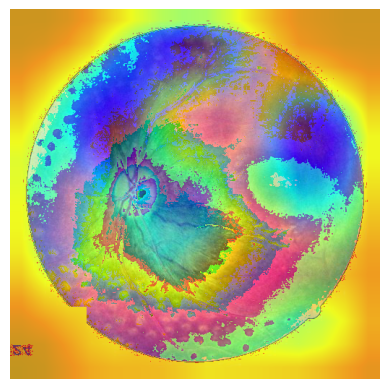

Grad-CAM visualization saved: ./plots/gradcam_sample_1.jpg


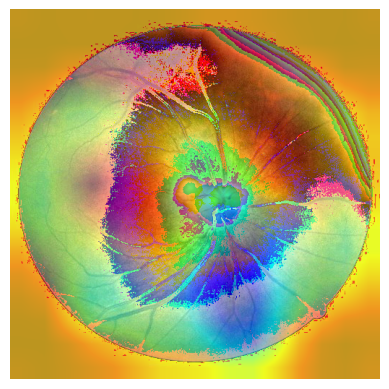

Grad-CAM visualization saved: ./plots/gradcam_sample_2.jpg


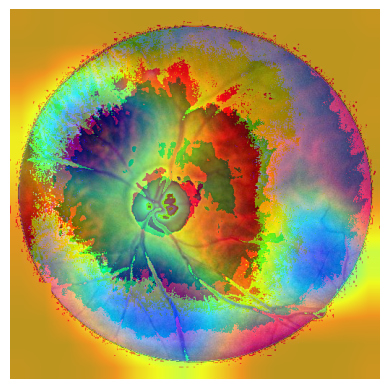

Grad-CAM visualization saved: ./plots/gradcam_sample_3.jpg


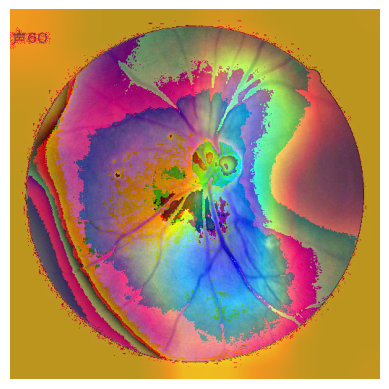

Grad-CAM visualization saved: ./plots/gradcam_sample_4.jpg


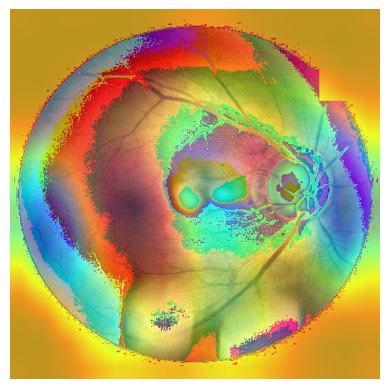

Grad-CAM visualization saved: ./plots/gradcam_sample_5.jpg
Combined Grad-CAM visualization saved: ./plots/gradcam_combined.jpg


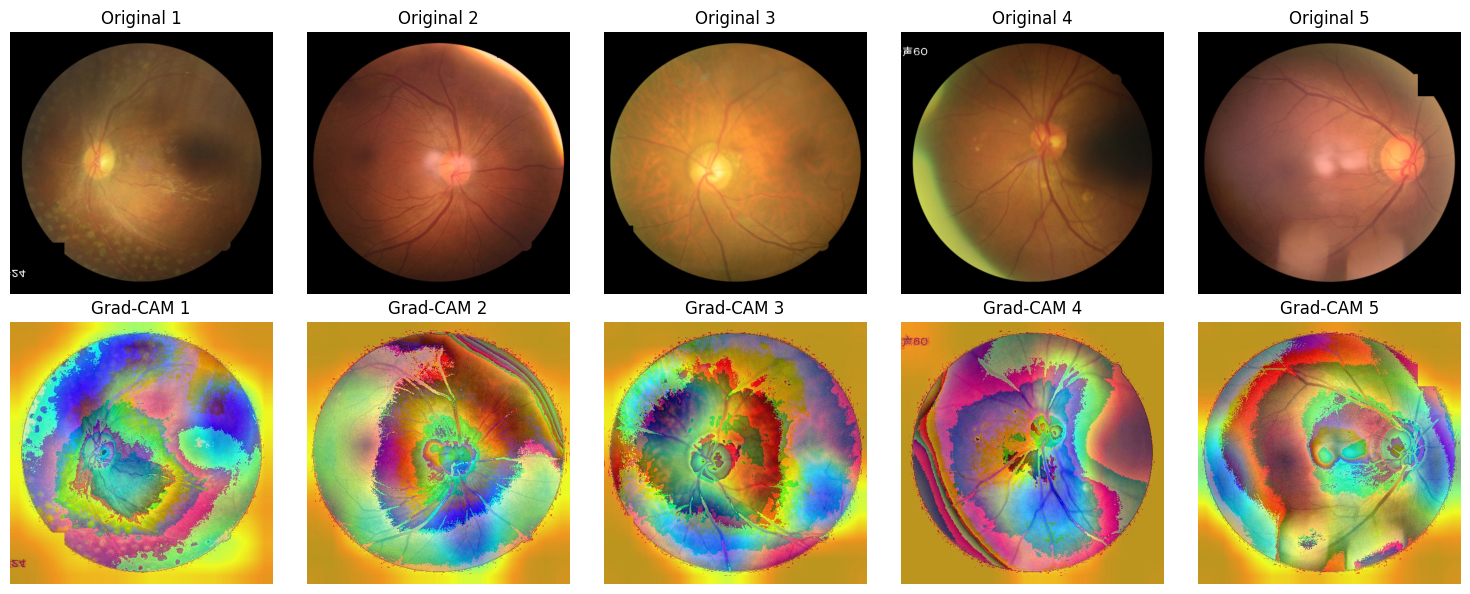

In [22]:
# Grad-CAM on 5 sample images from the train loader
if __name__ == '__main__':
    # Load model
    model_path = './models/partA_model_resnet18.pth'
    model = MyModel()  # Assume MyModel is the defined model class
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.to(device)

    train_dataset = RetinopathyDataset('./Data/DeepDRiD/train.csv', './Data/DeepDRiD/train/', transform=transform_train, mode='single')
    train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)

    # Process 5 sample images from the train loader
    num_samples = 5
    count = 0
    gradcam_images = []
    original_images = []

    # Grad-CAM visualizations for 5 sample images
    for count, (input_image, label) in enumerate(train_loader):
        if count == 5:  # Limit to 5 images
            break
    
        input_image = input_image[0]  # Get first image from batch
        original_image = to_pil_image(input_image.cpu())  # Convert tensor to PIL image
        
        # Generate Grad-CAM heatmap
        heatmap = grad_cam(model, input_image, device, model.backbone.layer4[-1])
    
        # Save the Grad-CAM visualization
        save_path = f"./plots/gradcam_sample_{count + 1}.jpg"
        visualize_grad_cam(heatmap, original_image, save_path=save_path, alpha=0.6)

        gradcam_images.append(cv2.cvtColor(cv2.imread(save_path), cv2.COLOR_BGR2RGB))

        # Denormalize the image to display correctly
        original_image = denormalize_image(input_image.cpu(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        original_images.append(np.array(original_image))
        
        # plt.savefig(save_path)
        print(f"Grad-CAM visualization saved: {save_path}")

    # Combine Grad-CAM visualizations into a single image grid
    fig, axs = plt.subplots(2, num_samples, figsize=(15, 6))

    for i in range(num_samples):
        # Original image
        axs[0, i].imshow(original_images[i])
        axs[0, i].axis('off')
        axs[0, i].set_title(f"Original {i+1}")

        # Grad-CAM image
        axs[1, i].imshow(gradcam_images[i])
        axs[1, i].axis('off')
        axs[1, i].set_title(f"Grad-CAM {i+1}")

    # Save the combined image
    combined_save_path = "./plots/gradcam_combined.jpg"
    plt.tight_layout()
    plt.savefig(combined_save_path)
    print(f"Combined Grad-CAM visualization saved: {combined_save_path}")
    plt.show()